<a href="https://colab.research.google.com/github/gptix/is-this-poisonous/blob/master/is_this_poisonous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Can I Eat This" Project
Lambda School Data Science Cohort 10 (go ***Laser Sharks!***)

This project is to develop a model that could be used to make predictions, trained on a dataset.

The model predicts, based on observed features of mushrooms, whether they are likely poisonous.

## Requirements for MVP

See checklist at bottom of this notebook.

At present, this notebook and other work are designed to fulfill the MVP requirements.

## Data
Data gotten from UCI **UC Irvine Machine Learning Repository**

https://archive.ics.uci.edu/ml/datasets/Mushroom

### Configure notebook kernel based on whether it is running on Colab or a 'local' machine.

In [71]:
%%capture
import sys

# If on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/gptix/Project2/master/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If local:
else:
    DATA_PATH = '../data/'
    !pip install xgboost
    !pip install graphviz
    !pipenv install pydotplus
    !pipenv install pdpbox.pdp

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

## Import data.
I created the column names by hand, based on notes on the data in the file 
agricus-lepiota.names at the DATA_PATH.

In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# I made the column names by copying descriptions from the file './data/agaricus-lepiota.names',
# then used lisp to extract column names, replace '-' with '_', then build a python list of strings.

colnames = ["poisonous", "cap_shape", "cap_surface", "cap_color", "bruises?", "odor", "gill_attachment",
           "gill_spacing", "gill_size", "gill_color", "stalk_shape", "stalk_root", 
           "stalk_surface_above_ring", "stalk_surface_below_ring", "stalk_color_above_ring", 
           "stalk_color_below_ring", "veil_type", "veil_color", "ring_number", "ring_type", 
           "spore_print_color", "population", "habitat"]
# colnames

# a file named 'expanded' is a CSV file with 'full-word' values instead of single-letter abbreviations.
# a number of header lines need to be skipped, and one footer line needs to be skipped.
df = pd.read_csv(DATA_PATH+'expanded', skiprows=9, skipfooter=3, 
                 engine='python', names=colnames, header=None)

### Do basic checks of data.

The data I got was very well prepared.

In [73]:
df.head()
df.columns
# df.tail()
df.isnull().sum()

poisonous                   0
cap_shape                   0
cap_surface                 0
cap_color                   0
bruises?                    0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_color_above_ring      0
stalk_color_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
dtype: int64

## Split dataframe into **X** matrix and $\hat{y}$ vector

We will use the 22 features to 'predict' whether an observed mushroom is poisonous or not.

$\hat{y}$ is simply the series of 'POISONOUS' and 'EDIBLE' values.

And **X** is the matrix of all other series.

In [74]:
target = 'poisonous'
features = df.columns.drop(target)

X = df[features]
y = df[target]
y.unique()

# X.isna().cap_shape.unique()

array(['EDIBLE', 'POISONOUS'], dtype=object)

## Convert categorical values in $\hat{y}$ into boolean values.
**This cell mutates the data in $\hat{y}$, so, if it needs to be run more than once, be sure to go back and re-run the code that sets $\hat{y}$**

In [75]:
# Define this outside the function, since we might use it later.
poisonTF = {'POISONOUS' : True, 'EDIBLE' : False}

def poison_to_bool(wrd):   
    return poisonTF.get(wrd)

# poison_to_bool('POISONOUS')

y = y.apply(poison_to_bool)
y

0       False
1       False
2       False
3       False
4       False
        ...  
8409    False
8410    False
8411    False
8412    False
8413    False
Name: poisonous, Length: 8414, dtype: bool

In [76]:
# # Transform string values to category values, then to integers
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# le.fit(y)
# list(le.classes_)

# y = le.transform(y)

# # Note: EDIBLE = 0, POISONOUS = 1
# # since this mutates the data in y, transforming again will lose the relation between the old, string 
# # data and the new, numeric data.
# # To get back, re-run code at and after definition of df.

# # Get sample of inversion of transformation.
# reverse_transform_of_0_1_1 = list(le.inverse_transform([0, 1, 1]))

# reverse_transform_of_0_1_1

# # df.head()

## Split **X** and $\hat{y}$ into subsets for training, validation, and final testing.

In [77]:
from sklearn.model_selection import train_test_split
# Split train into train & val
# train, test = train_test_split(df, train_size=0.90, test_size=0.10, random_state=43)
# train, val = train_test_split(train, train_size=0.90, test_size=0.10, random_state=43)

# The 'train' data from this step will be split again, below.
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.10, random_state=42)

# In the line below, 'test_size' is used to specify the size of the val set.
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.11, random_state=42)

## **Visualization 1**: - Basic histogram
Take a look at the distribution of **POISONOUS** and **EDIBLE**.


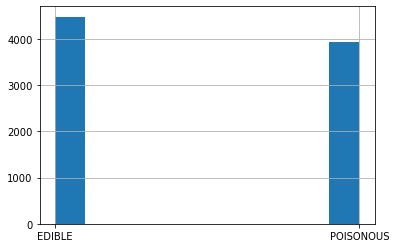

In [78]:
df[target].hist();

## Get a baseline, to use in evaluating subsequent models.

In [79]:
# Get a baseline
baseline_edible = df[target].value_counts(normalize=True).max()
print(f'Baseline, guessing \'edible\', would be right {round(100 * baseline_edible,1)}% of the time.\n')

Baseline, guessing 'edible', would be right 53.3% of the time.



## (Build and) Fit a Linear Regression model

In [80]:
# We need to convert categorical values to numeric values. 
import category_encoders as ce

# We will use a straightforward linear regression.
from sklearn.linear_model import LinearRegression

# We will use 'make_pipeline' to create a 'composition' of two classes.
from sklearn.pipeline import make_pipeline

# This instantiates and composes.  Really cool.
lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

# Use the instance of the model to fit to training features, and evaluate with training target output.
lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['cap_shape', 'cap_surface', 'cap_color',
                                     'bruises?', 'odor', 'gill_attachment',
                                     'gill_spacing', 'gill_size', 'gill_color',
                                     'stalk_shape', 'stalk_root',
                                     'stalk_surface_above_ring',
                                     'stalk_surface_below_ring',
                                     'stalk_color_above_ring',
                                     'stalk_color_below_ring', 'veil_type',
                                     'veil_color', 'ring_number', 'ring_type',
                                     'spore_print_color', 'population',
                                     'habitat'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                       

# Evaluate Linear Model using **R^2**

In [81]:
r2 = lr.score(X_val, y_val)
print('Linear Regression R^2', r2)

Linear Regression R^2 0.953754111853193


### Explaining Linear Regression

Some correlations are strong (e.g., **odor**), while some are very weak (e.g., **veil_type**)

In [82]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

cap_shape                  -8.055346e-02
cap_surface                -8.646570e-03
cap_color                   7.811439e-02
bruises?                   -9.004907e-02
odor                        8.740933e-01
gill_attachment            -7.223457e-01
gill_spacing               -3.924363e-03
gill_size                   1.767757e-01
gill_color                  2.777067e-02
stalk_shape                -6.891734e-02
stalk_root                 -2.740849e-01
stalk_surface_above_ring    2.391825e-02
stalk_surface_below_ring   -4.068485e-02
stalk_color_above_ring      1.234253e-02
stalk_color_below_ring      3.798026e-02
veil_type                  -1.561251e-16
veil_color                  1.867981e-01
ring_number                -2.447269e-01
ring_type                  -1.639383e-02
spore_print_color           2.341796e-01
population                  1.218227e-01
habitat                    -5.284412e-02
dtype: float64

## (Build and) Fit a Tree Classifier

In [83]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=6)
)

pipeline.fit(X_train, y_train)
print() # control whether Pipeline definition is printed.

## Evaluate Accuracy of Tree Classifier

In [84]:
va = pipeline.score(X_val, y_val)
print(f'Validation Accuracy: {va}')

Validation Accuracy: 0.9903961584633854


## Calculate Recall Score of DecisionTreeClassifier on **Validation** set.

I use **Recall** as an evaluation metric since the cost of a **false edible** is high.

In [85]:
from sklearn.metrics import recall_score
y_pred_val = pipeline.predict(X_val)

recall_val = recall_score(y_val, y_pred_val)
print('Recall score on Validation set: ', recall_val)

Recall score on Validation set:  1.0


## Calculate Recall Score of DecisionTreeClassifier on **Test** set.

In [86]:
y_pred_test = pipeline.predict(X_test)

recall_test = recall_score(y_test, y_pred_test)
print('Recall score on TEST set: ', recall_test)

Recall score on TEST set:  1.0


## **Visualization 2**: Display Decision Tree (**True == Poisonous**)

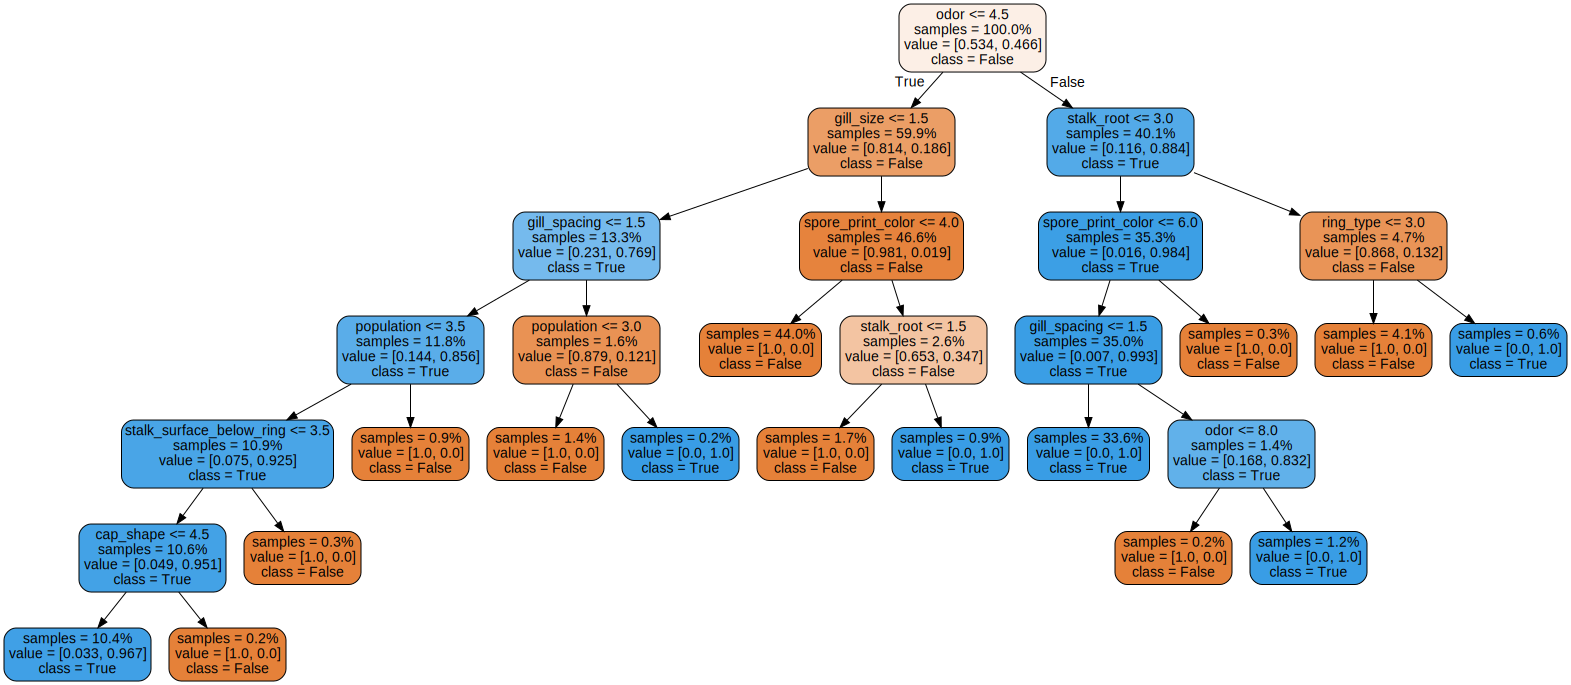

In [87]:
import graphviz
from sklearn.tree import export_graphviz
# import pydotplus

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    out_file = None,
    feature_names = X_train.columns,
    class_names = y.unique().astype(str),
    filled = True,
    impurity=False,
    proportion=True,
    rounded=True
)

graphviz.Source(dot_data)

## Use XGBoost

In [88]:
# Use PDP with categorical data

import category_encoders as ce
# Use Ordinal Encoder, outside of a pipeline

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

encoder = ce.OrdinalEncoder()
X_temp = df[features]
X_encoded = encoder.fit_transform(X_temp)


# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

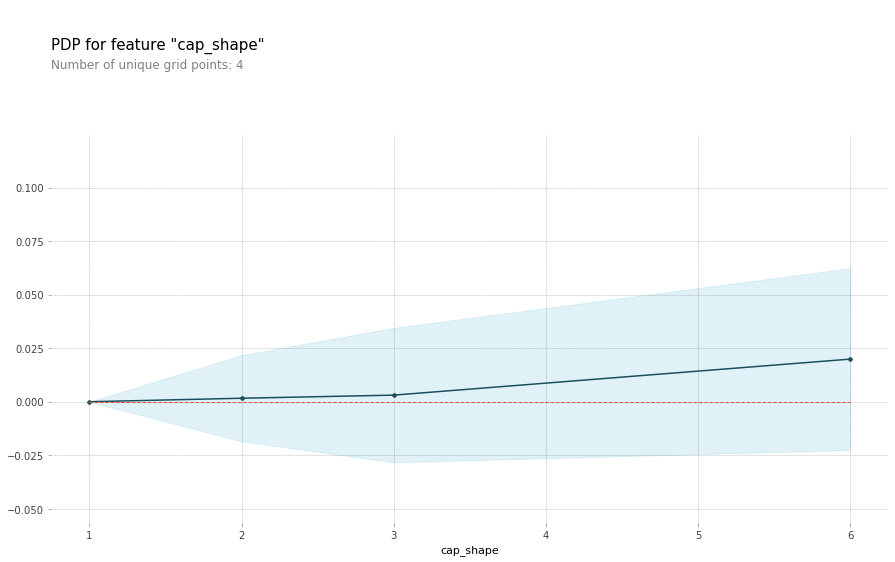

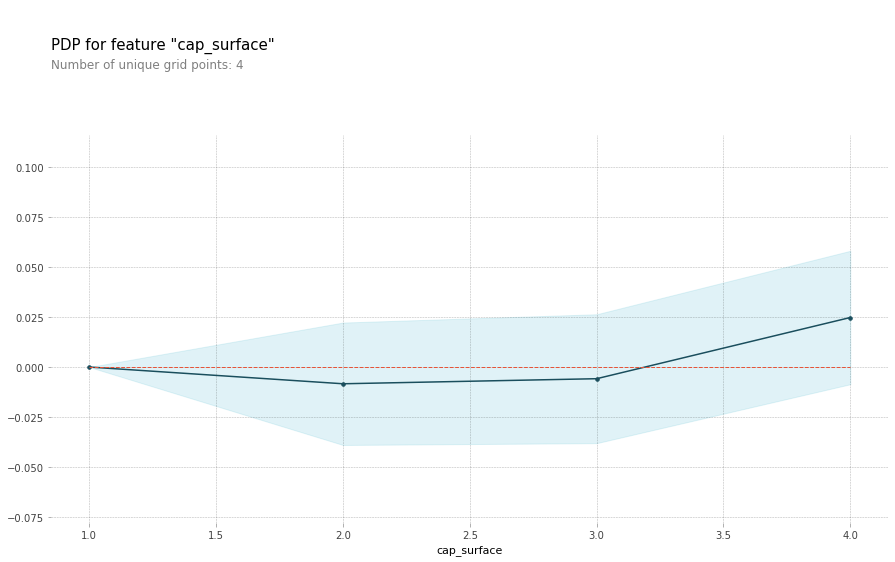

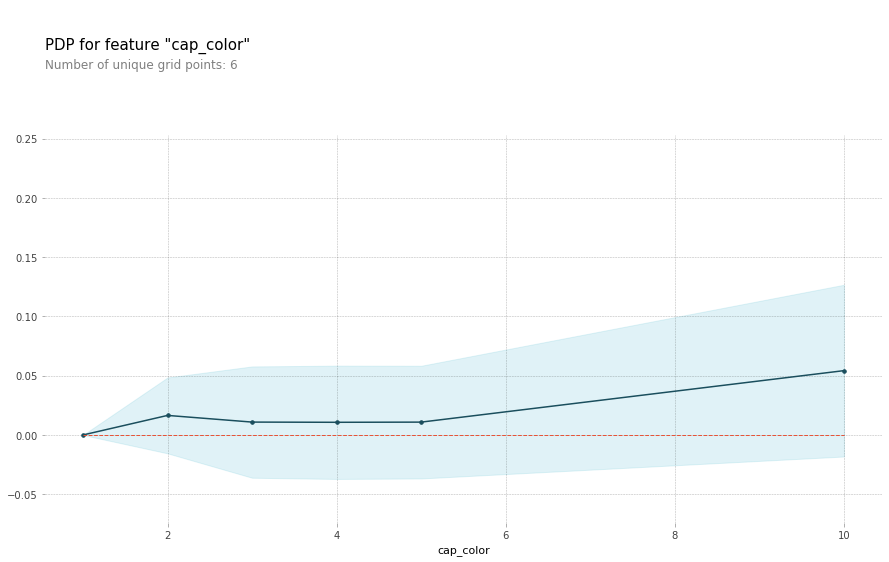

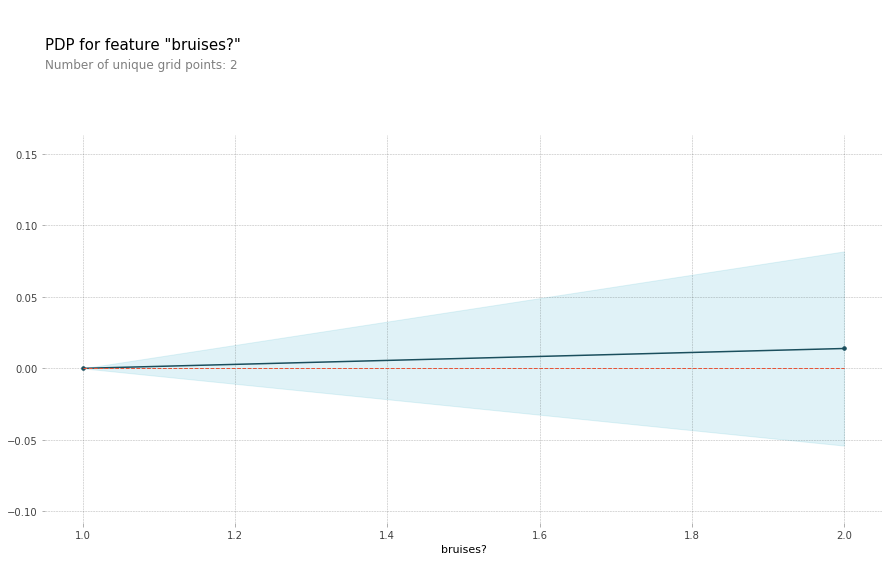

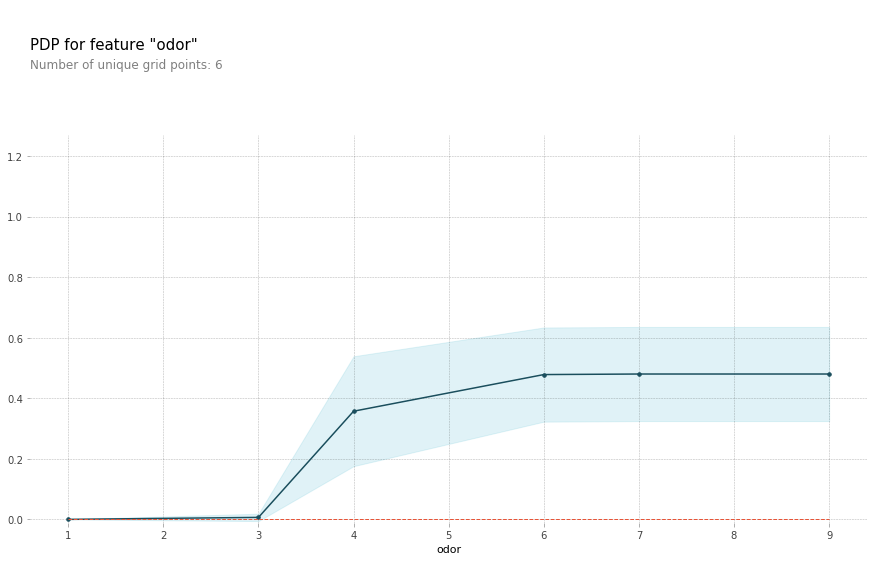

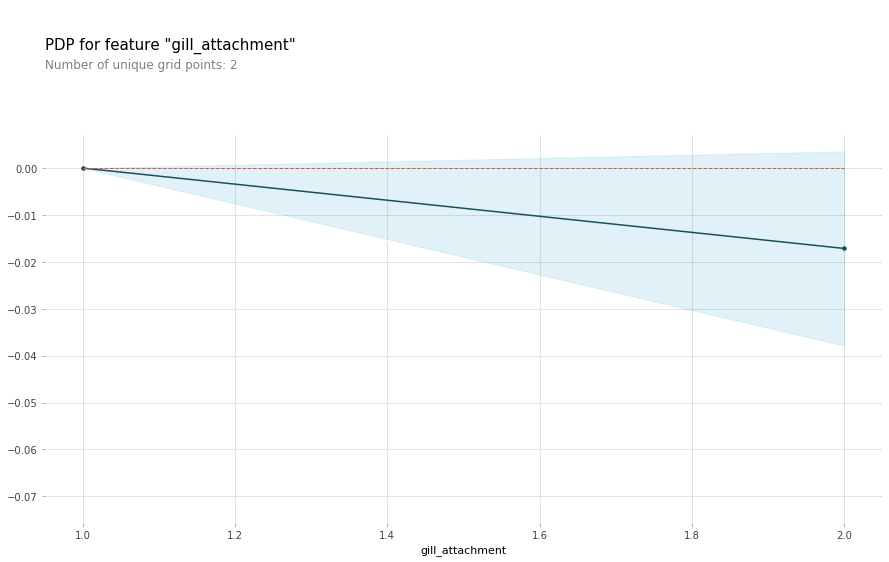

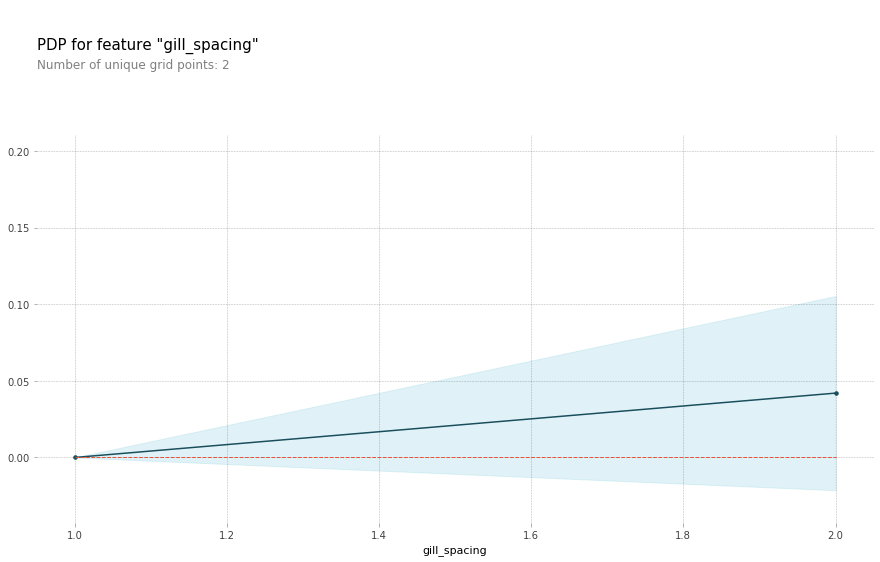

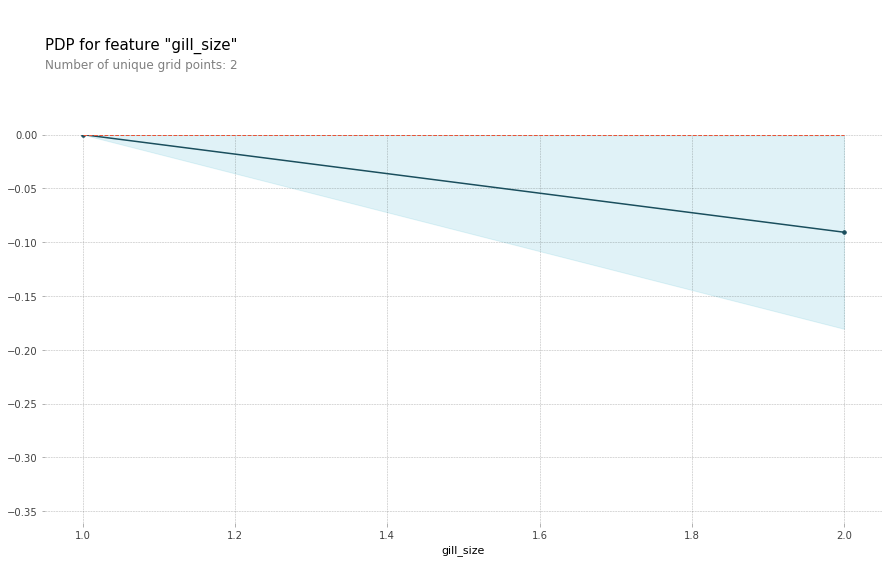

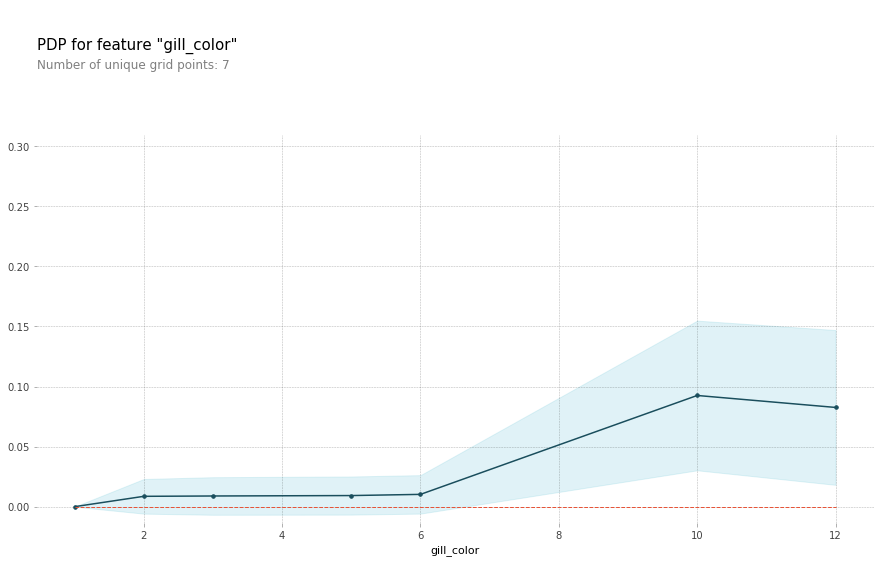

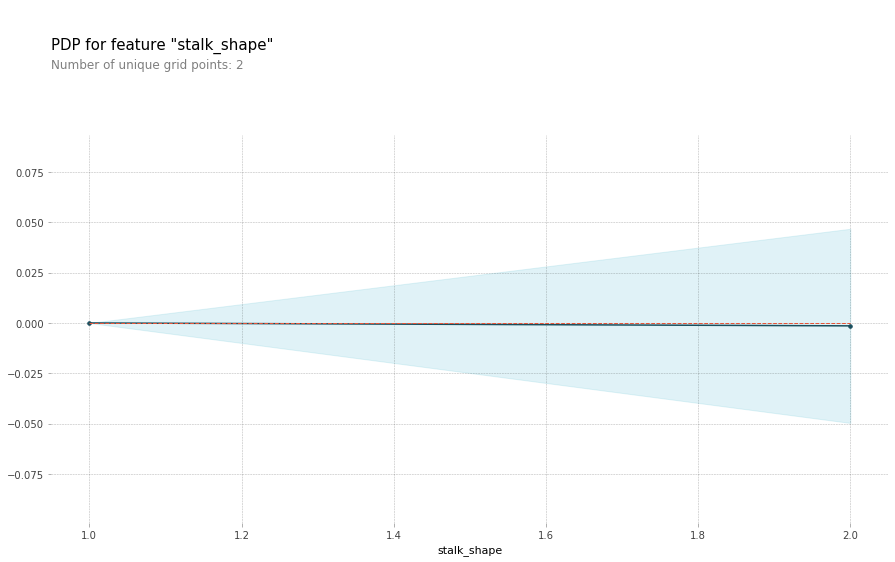

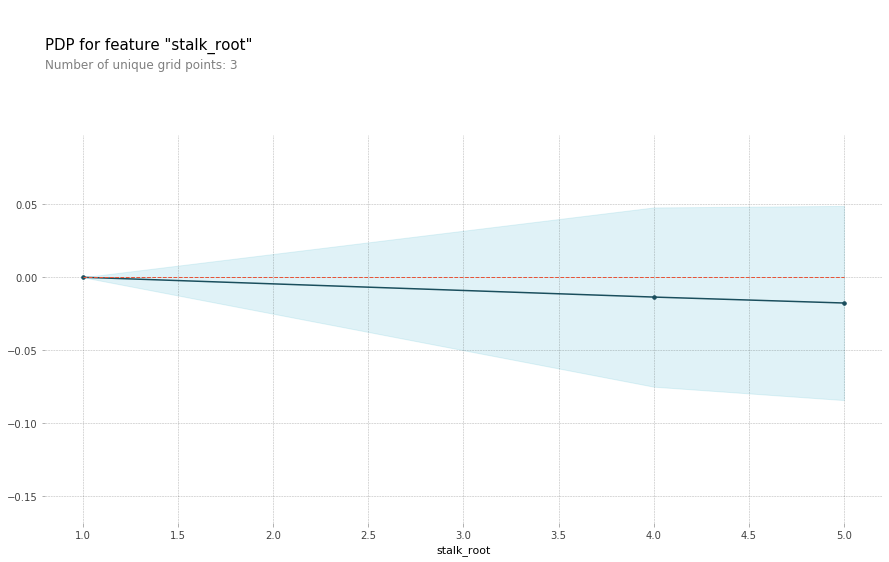

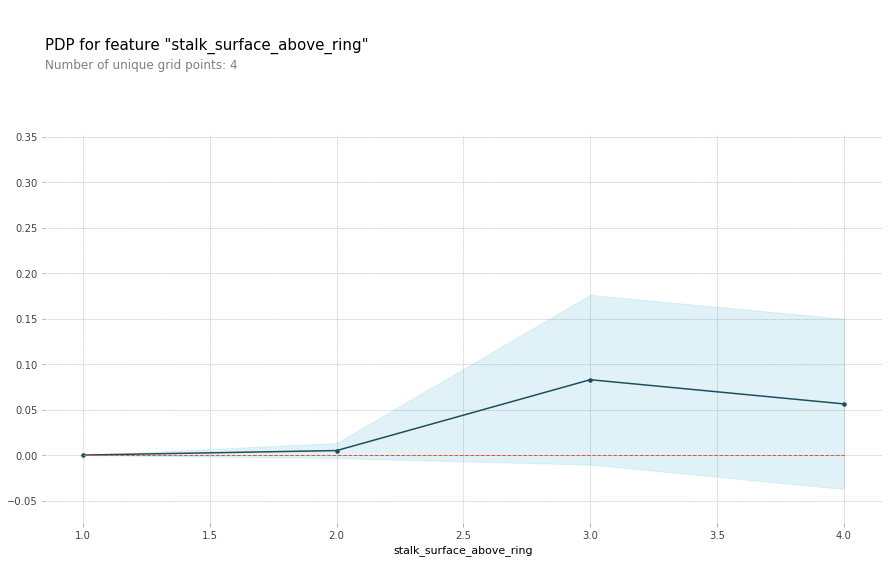

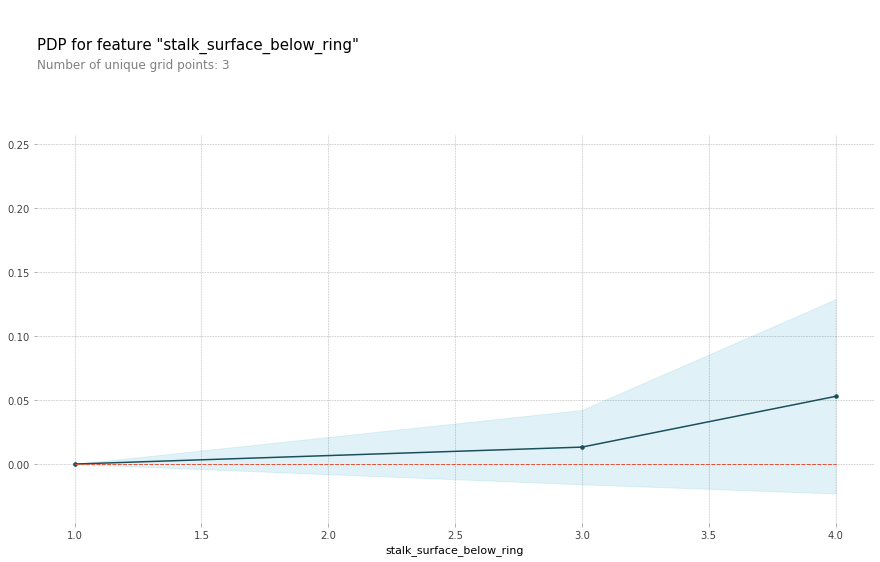

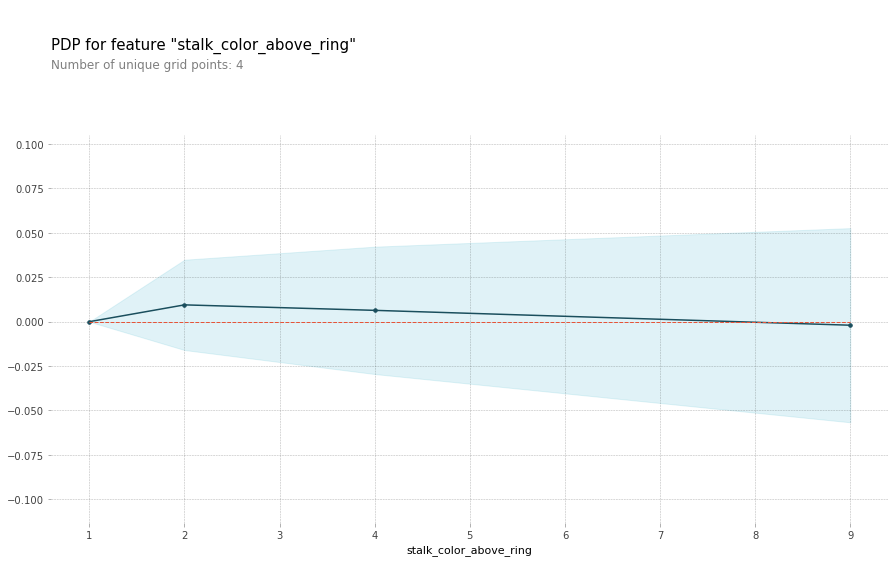

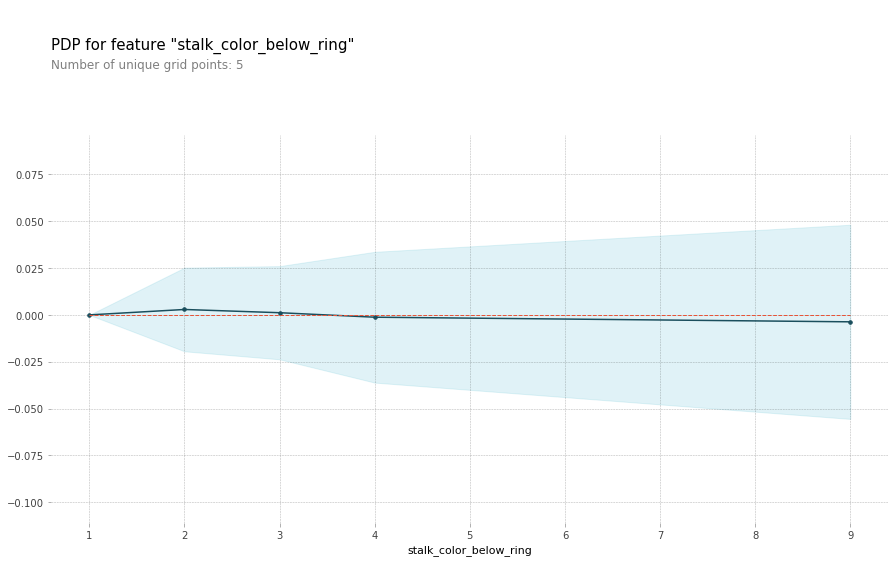

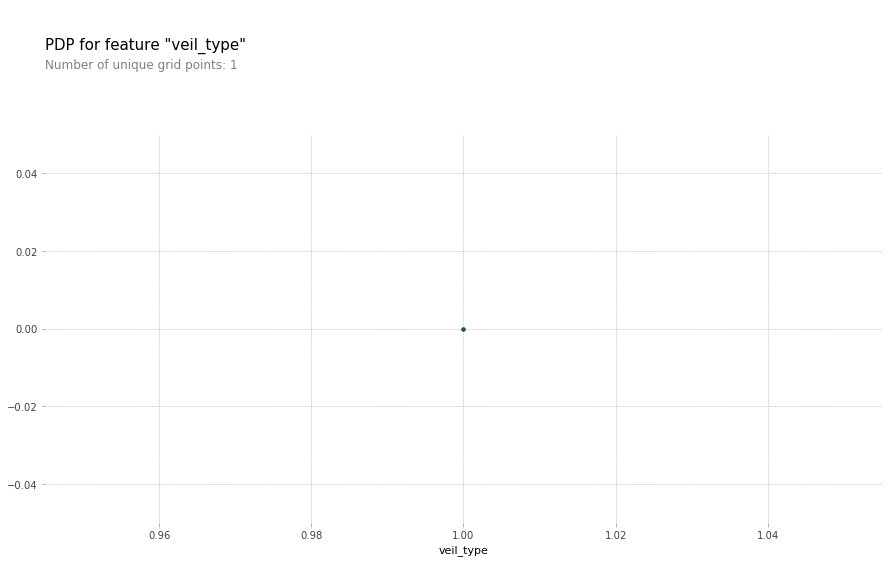

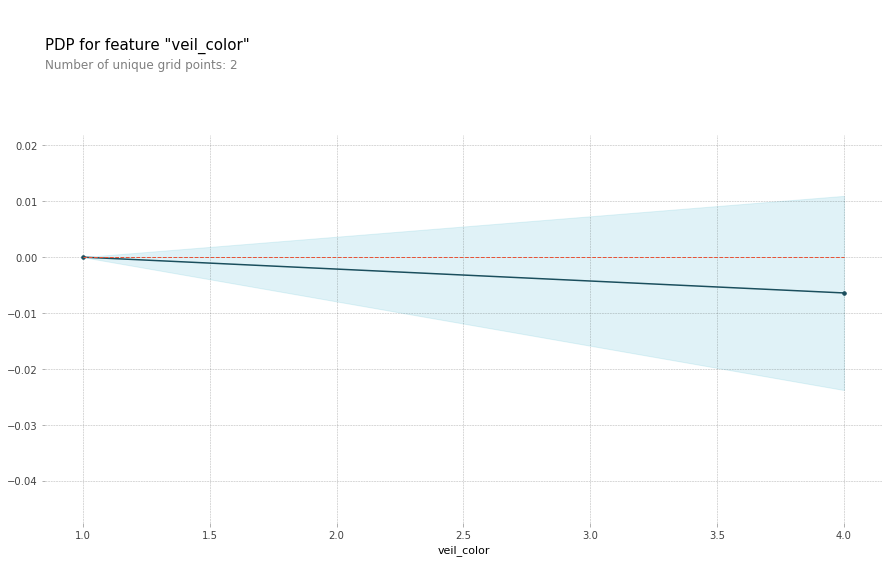

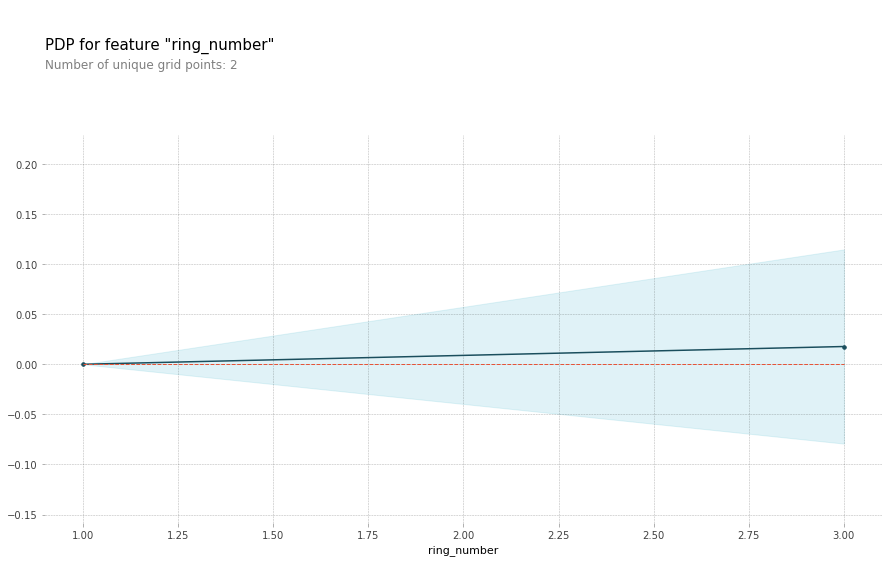

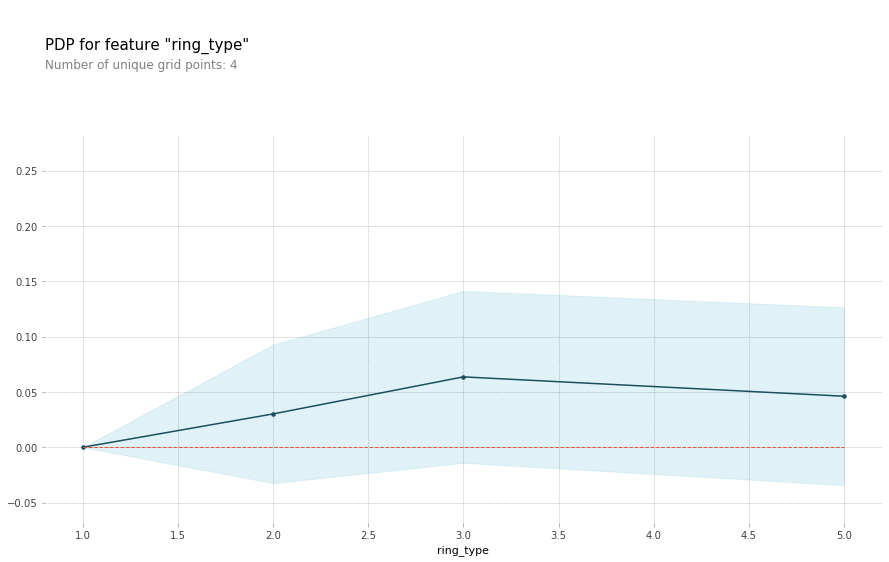

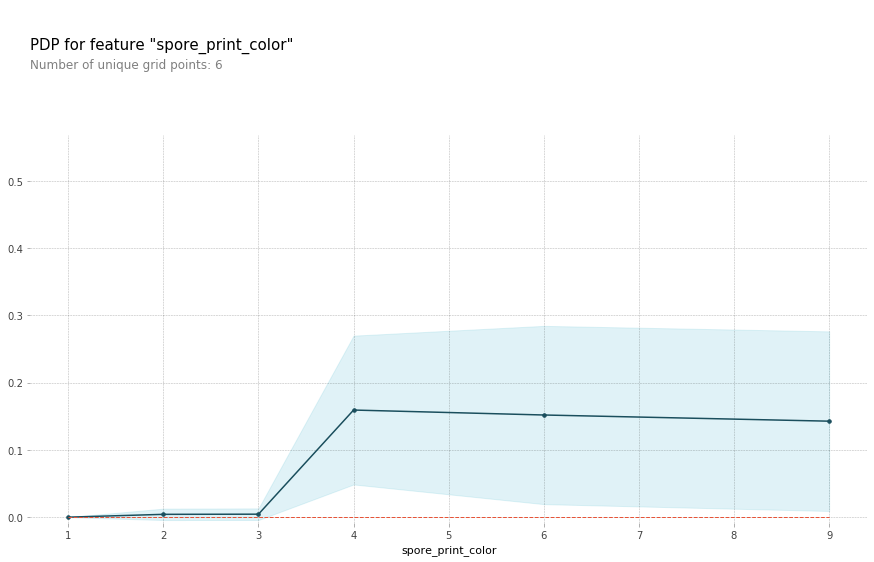

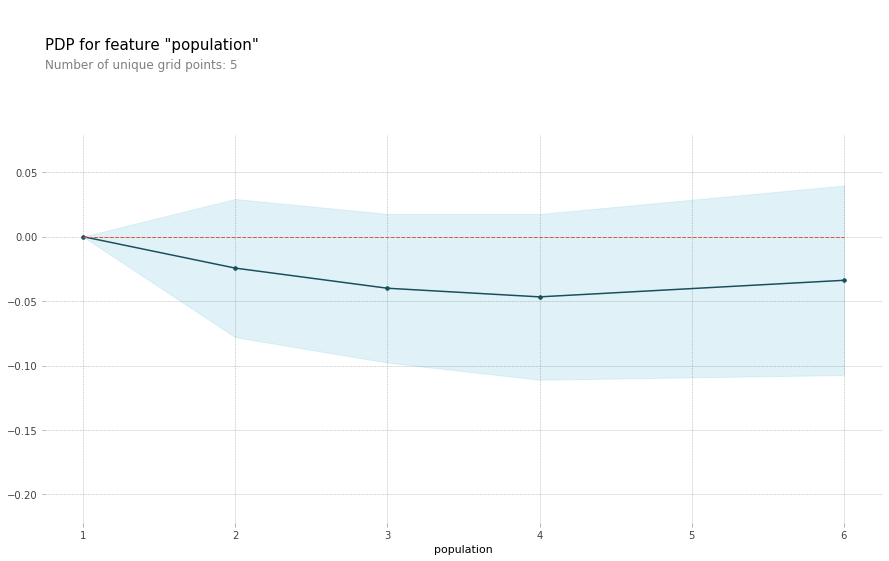

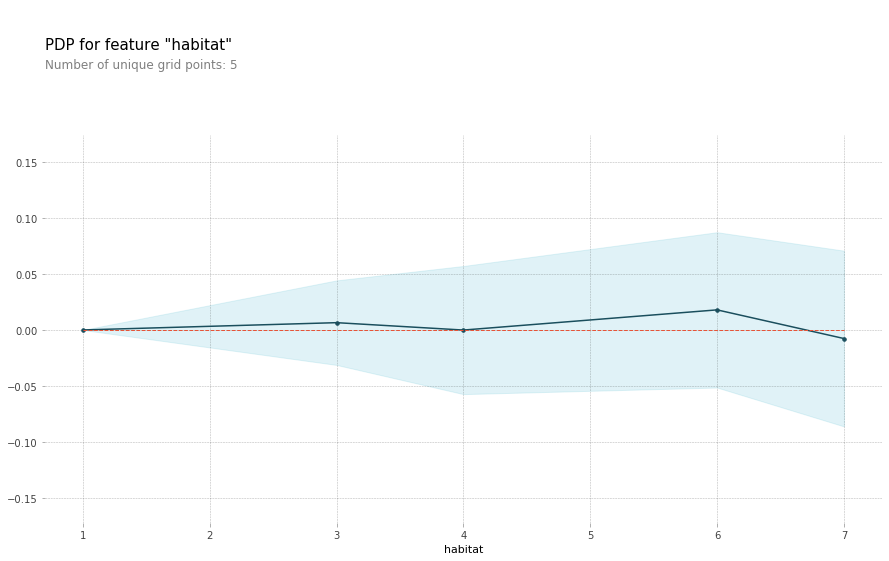

In [89]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp

feature = 'cap_color'

for f in features:
    pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=f)
    pdp.pdp_plot(pdp_dist, f);    

In [90]:
cat_num_mapping = encoder.mapping

list(cat_num_mapping[0]['mapping'].index)
list(cat_num_mapping[0]['mapping'].values)
cat_num_mapping[0]['mapping']
# list(cat_num_mapping[0]['mapping'])
# cat_num_mapping[0]['mapping']

CONVEX     1
FLAT       2
BELL       3
SUNKEN     4
KNOBBED    5
CONICAL    6
NaN       -2
dtype: int64

In [98]:
for f in features:
    for item in encoder.mapping:
        if item['col'] == f:
            feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

In [99]:
feature_mapping

WOODS      1
MEADOWS    2
GRASSES    3
PATHS      4
URBAN      5
LEAVES     6
WASTE      7
dtype: int64

In [91]:
# Transform string values to category values, then to integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


# X.head()
# le.fit(X.iloc[0])
# list(le.classes_)

# y_transformed = le.transform(y)

# X_transformed = le.transform(X)

# Note: EDIBLE = 0, POISONOUS = 1
# since this mutates the data in y, transforming again will lose the relation between the old, string 
# data and the new, numeric data.
# To get back, re-run code at and after definition of df.

# Get sample of inversion of transformation.
# reverse_transform_of_0_1_1 = list(le.inverse_transform([0, 1, 1]))

# reverse_transform_of_0_1_1

# df.head()

# features

In [92]:
# features

In [93]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.9942055732748908


In [94]:
# plot feature importance
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance

plt.rcParams['figure.dpi'] = 72

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'cap_color'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

# XGBmodel = XGBClassifier()
# XGBmodel.fit(X, y)

# # plot feature importance
# plot_importance(model)
# pyplot.show()

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier with Ordinal Encoder
RFC_ord_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=1984, n_jobs=-1, n_estimators=100)
)

RFC_ord_pipeline.fit(X_train, y_train)
print('Validation Accuracy', RFC_ord_pipeline.score(X_val, y_val))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

y_pred = RFC_ord_pipeline.predict(X_val)

def plot_cfz_matrix(y_true, y_predicted):
  ul = unique_labels(y_val)
  cols = [f'Predicted {label}' for label in ul]
  idx = [f'Actual {lbl}' for lbl in ul]
  return pd.DataFrame(confusion_matrix(y_true, y_predicted),
                      columns=cols, index=idx)

plot_cfz_matrix(y_val, y_pred)

## Report (MVP)

In [ ]:
print("Report")
print()
print(f'Baseline (guessing \'edible\'):    {round(100 * baseline_edible,1)}% of the time.')
print()
print(f'Linear Regression R^2:           {r2}')
print(f'Validation Accuracy:             {va}')
print()
print('Evaluation metric is RECALL')
print()
print(f'Recall score on VALIDATION set:  {recall_val}' )
print()
print(f'Recall score on TEST set:        {recall_test}')

In [ ]:
#--------------------------------------------------------------

--------------------

# Checklist

*Don't let the perfect be the enemy of the good.*

## The Good

- Publish a blog post (**done**, [https://gptix.github.io/2020-01-08-poisonYN/](https://gptix.github.io/2020-01-08-poisonYN/) )

- Choose a 
  - target, (feature named **poisonous**)
  - evaluation metric (**I choose recall**), and 
  - baseline (**53.3% chance of being correct if we always guess 'edible'**)
    
  for a 
  - regression, 
  - binary classification (**my choice**), or 
  - multi-class classification problem, 
  
  with their labeled, tabular dataset.
  
- Fit and evaluate
  - any linear model (**Linear Regression**)
  
  for 
  
  - regression or 
  - classification (**my choice**)
  
- Fit and evaluate 
  - a decision tree (**my choice**), 
  - random forest, or 
  - gradient boosting model 
    
  Student writes 300+ words (not including code) (**done**)
  
  Student reports 
  - baseline score (**done**)
  - validation scores from 2+ models
    - Linear Regression - (**done**) 
    - Decision Tree Classifier - (**done**)
    and 
    test score from 1 selected model
  - Decision Tree Classifier - (**done**)
 
  
  Student makes 2+ visualizations to explain their model
  - Historgram for baseline
  - Decision Tree flow
  
  Student commits all code to GitHub. 
  Notebooks have no error messages.
  

## The Perfect
- [ ] visualize feature importances
- [ ] measure correlations of two most important features
- [ ] visualize these
- [ ] make an app

In [ ]:
df.head()

# Improve by correlating categorical values with target


In [ ]:
# check types of features (and target)
df.dtypes

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X, y)
# for name, importance in zip(iris["feature_names"], rnd_clf.feature_importances_):
#      print(name, "=", importance)